# Practical 1 - Autoencoders & Latent Spaces (Embeddings)

**Road to SKA: Foundation Models, Embeddings, and Latent Spaces**

In this practical you will:

1. Train a small **autoencoder** on an image dataset (default: MNIST).
2. Extract **latent vectors** (embeddings) and visualise the latent space with **PCA** (and optionally **UMAP**).
3. Explore latent-space operations:
   - **Interpolation** between examples
   - **Latent traversals** - vary one latent dimension and decode

This notebook is designed to be **CPU-friendly**.

---

## Datasets & references

**Datasets**
- MNIST: http://yann.lecun.com/exdb/mnist/  
- Fashion-MNIST: https://github.com/zalandoresearch/fashion-mnist  
- MiraBest (radio galaxies, Zenodo): https://doi.org/10.5281/zenodo.4288837  
  Paper: https://academic.oup.com/rasti/article/2/1/293/7202349  

**Core references**
- Hinton & Salakhutdinov (2006), *Reducing the Dimensionality of Data with Neural Networks* (autoencoders): https://www.cs.toronto.edu/~hinton/absps/science.pdf  
- Kingma & Welling (2013), *Auto-Encoding Variational Bayes* (VAE concept): https://arxiv.org/abs/1312.6114  
- McInnes et al. (2018), *UMAP* (visualisation): https://arxiv.org/abs/1802.03426  
- PyTorch/Torchvision dataset docs: https://docs.pytorch.org/vision/main/datasets.html


## 1. Environment setup

The [README.md](README.md) file provides instructions on setting up a Conda environment for running the tutorial. Please [install Anaconda](https://www.anaconda.com/docs/getting-started/miniconda/main) and create the `r2ska-tutorial` environment before running this notebook.

In [1]:
import os
import math
import random
from dataclasses import dataclass, fields
from typing import Tuple, Optional

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms


## 2. Configuration

Use the config below to control:
- dataset choice (MNIST / Fashion-MNIST)
- training size (subset for speed)
- latent dimension
- epochs and batch size

**Tip:** start small (e.g. `max_train_samples=10000`, `epochs=3`) on CPU.


In [2]:
# Control the experiment via a dataclass
@dataclass
class Config:
    dataset: str = "mnist"       # "mnist" or "fashion_mnist"
    data_dir: str = "./data"
    batch_size: int = 128
    epochs: int = 5
    lr: float = 1e-3
    latent_dim: int = 16
    max_train_samples: Optional[int] = 20000   # None for full set
    max_test_samples: Optional[int] = 5000     # None for full set
    seed: int = 42

    # Formatted string representation for readable output
    def __repr__(self):
        lines = [f"{self.__class__.__name__}:"]
        for f in fields(self):
            lines.append(f"  {f.name:20s} = {getattr(self, f.name)!r}")
        return "\n".join(lines)

cfg = Config()

# Set a consistent random seed for reproducibility
random.seed(cfg.seed)
np.random.seed(cfg.seed)
torch.manual_seed(cfg.seed)

# Select accelerated device, if available: CUDA > MPS (Apple Silicon) > CPU
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print("Device:", device)
print(cfg)

Device: mps
Config:
  dataset              = 'mnist'
  data_dir             = './data'
  batch_size           = 128
  epochs               = 5
  lr                   = 0.001
  latent_dim           = 16
  max_train_samples    = 20000
  max_test_samples     = 5000
  seed                 = 42


## 3. Load dataset

We use torchvision datasets for convenience. They download automatically into `data_dir`.
Images are scaled to `[0, 1]`.

If you'd like a radio-astronomy-flavoured dataset, see the **MiraBest extension** near the end.


Train samples: 20000
Test samples:  5000
Batch: torch.Size([128, 1, 28, 28]) torch.Size([128])


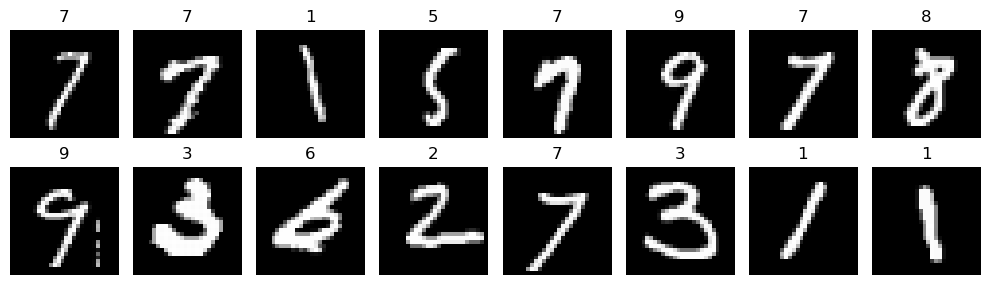

In [3]:
def get_datasets(cfg: Config):
    """
    Load datasets based on name specified in the configuration.
    Train and test splits have already been separated and are returned as 
    separate datasets. The dataset format is a torchvision.datasets object.

    Args:
        cfg: Configuration object with dataset parameters.

    Returns:
        train_ds: Training dataset.
        test_ds: Testing dataset.
        n_classes: Number of classes in the dataset.
    """
    tfm = transforms.Compose([
        transforms.ToTensor(),  # -> [0,1]
    ])
    if cfg.dataset.lower() == "mnist":
        train_ds = datasets.MNIST(root=cfg.data_dir, train=True, download=True, transform=tfm)
        test_ds  = datasets.MNIST(root=cfg.data_dir, train=False, download=True, transform=tfm)
        n_classes = 10
    elif cfg.dataset.lower() in ["fashion_mnist", "fashion-mnist", "fmnist"]:
        train_ds = datasets.FashionMNIST(root=cfg.data_dir, train=True, download=True, transform=tfm)
        test_ds  = datasets.FashionMNIST(root=cfg.data_dir, train=False, download=True, transform=tfm)
        n_classes = 10
    else:
        raise ValueError("Unknown dataset. Use 'mnist' or 'fashion_mnist'.")
    return train_ds, test_ds, n_classes

train_ds, test_ds, n_classes = get_datasets(cfg)


def select_subset(ds, max_n: Optional[int], seed: int = 0):
    """
    Return a random subset of the dataset if max_n is specified and less than
    the dataset size. Otherwise, return the original dataset.

    Args:
        ds: The original dataset.
        max_n: Maximum number of samples to include in the subset.
        seed: Random seed for reproducibility.

    Returns:
        A subset of the dataset or the original dataset.
    """
    if max_n is None or max_n >= len(ds):
        return ds
    rng = np.random.default_rng(seed)
    idx = rng.choice(len(ds), size=max_n, replace=False)
    return Subset(ds, idx)

# Subsample the datasets if specified in the config
train_ds_small = select_subset(train_ds, cfg.max_train_samples, seed=cfg.seed)
test_ds_small  = select_subset(test_ds, cfg.max_test_samples, seed=cfg.seed + 1)

# Create PyTorch DataLoaders that will provide batches during training/testing
# num_workers=0 for compatibility (set higher if multiprocessing works on your system)
train_loader = DataLoader(train_ds_small, batch_size=cfg.batch_size, shuffle=True, num_workers=0, pin_memory=True)
test_loader  = DataLoader(test_ds_small,  batch_size=cfg.batch_size, shuffle=False, num_workers=0, pin_memory=True)

print("Train samples:", len(train_ds_small))
print("Test samples: ", len(test_ds_small))

# Peek at a few examples using matplotlib
x0, y0 = next(iter(train_loader))
print("Batch:", x0.shape, y0.shape)
fig, axes = plt.subplots(2, 8, figsize=(10, 3))
for i, ax in enumerate(axes.flat):
    ax.imshow(x0[i,0].numpy(), cmap="gray")
    ax.set_title(int(y0[i]))
    ax.axis("off")
plt.tight_layout()
plt.show()

## 4. Define a small convolutional autoencoder

We build:
- **Encoder:** Conv > Conv > Flatten > Linear > latent vector `z`
- **Decoder:** Linear > reshape > ConvTranspose > ConvTranspose > reconstruction `x_hat`

This is intentionally small and fast.


In [4]:
class ConvAutoencoder(nn.Module):
    """
    Convolutional Autoencoder for 28x28 grayscale images.

    Args:
        latent_dim: Dimension of the latent space.
    """

    # Initialize the autoencoder architecture
    def __init__(self, latent_dim: int = 16):
        super().__init__()
        # Input: (B, 1, 28, 28)
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  # -> (B,16,14,14)
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # -> (B,32,7,7)
            nn.ReLU(),
        )
        self.enc_fc = nn.Linear(32 * 7 * 7, latent_dim)

        self.dec_fc = nn.Linear(latent_dim, 32 * 7 * 7)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 4, stride=2, padding=1),  # -> (B,16,14,14)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 4, stride=2, padding=1),   # -> (B,1,28,28)
            nn.Sigmoid(),  # ensures output in [0,1]
        )

    # Encode input images to latent space
    def encode(self, x):
        h = self.encoder(x)
        h = h.view(h.size(0), -1)
        z = self.enc_fc(h)
        return z

    # Decode latent vectors back to images
    def decode(self, z):
        h = self.dec_fc(z)
        h = h.view(h.size(0), 32, 7, 7)
        x_hat = self.decoder(h)
        return x_hat

    # Full forward pass: encode then decode
    def forward(self, x):
        z = self.encode(x)
        x_hat = self.decode(z)
        return x_hat, z

# Instantiate the model on the device
model = ConvAutoencoder(latent_dim=cfg.latent_dim).to(device)
print(model)

# Set the loss function and optimizer
loss_fn = nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=cfg.lr)

ConvAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
  )
  (enc_fc): Linear(in_features=1568, out_features=16, bias=True)
  (dec_fc): Linear(in_features=16, out_features=1568, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(16, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): Sigmoid()
  )
)


## 5. Train the encoder

We minimise reconstruction MSE between `x` and `x_hat`.

On CPU, try:
- `epochs=3–5`
- `max_train_samples=10k–20k`


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1 [train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 1 [test]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 01 | train 0.08780 | test 0.06374


Epoch 2 [train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 2 [test]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 02 | train 0.04296 | test 0.02839


Epoch 3 [train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 3 [test]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 03 | train 0.02425 | test 0.02092


Epoch 4 [train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 4 [test]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 04 | train 0.02014 | test 0.01855


Epoch 5 [train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 5 [test]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 05 | train 0.01830 | test 0.01713


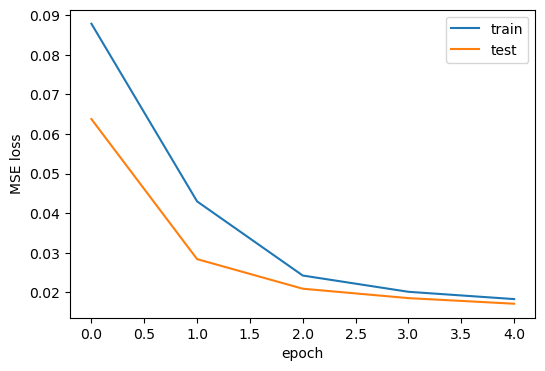

In [5]:
from tqdm.auto import tqdm

def run_epoch(model, loader, train: bool, desc: str = ""):
    """
    Run one epoch of training or evaluation.

    Args:
        model: The autoencoder model.
        loader: DataLoader providing the data.
        train: If True, run in training mode; otherwise, evaluation mode.
        desc: Description for the progress bar.

    Returns:
        Average loss over the epoch.     
    """
    model.train(train) # NB: set train mode
    total_loss = 0.0
    n = 0

    # Progress bar for the epoch
    pbar = tqdm(loader, desc=desc, leave=False)
    for x, _y in pbar:
        x = x.to(device)
        if train:
            opt.zero_grad(set_to_none=True)  # NB: reset gradients at start of step

        # Forward pass
        x_hat, _z = model(x)
        loss = loss_fn(x_hat, x)

        # Backward pass and optimization step
        if train:
            loss.backward()
            opt.step()

        # Accumulate loss
        bs = x.size(0)
        total_loss += loss.item() * bs
        n += bs

        # Update progress bar
        pbar.set_postfix(loss=total_loss / n)
    return total_loss / max(n, 1)

# Record training history here
history = {"train_loss": [], "test_loss": []}

# Main training loop
for epoch in tqdm(range(1, cfg.epochs + 1), desc="Training"):
    tr = run_epoch(model, train_loader, train=True, desc=f"Epoch {epoch} [train]")
    te = run_epoch(model, test_loader, train=False, desc=f"Epoch {epoch} [test]")
    history["train_loss"].append(tr)
    history["test_loss"].append(te)
    print(f"Epoch {epoch:02d} | train {tr:.5f} | test {te:.5f}")

# Plot training and test loss over epochs
plt.figure(figsize=(6,4))
plt.plot(history["train_loss"], label="train")
plt.plot(history["test_loss"], label="test")
plt.xlabel("epoch")
plt.ylabel("MSE loss")
plt.legend()
plt.show()

## 6. Visualise reconstructions

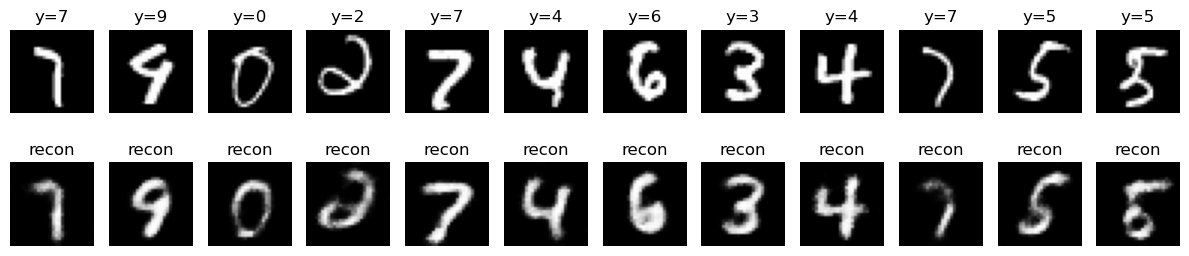

Latent batch shape: torch.Size([128, 16])


In [6]:
# Visualize some reconstructions from the test set

# Set model to evaluation mode
model.eval()

# Get a batch of test data
x, y = next(iter(test_loader))
x = x.to(device)

# Disable gradient calculations and get reconstructions
with torch.no_grad():
    # Forward pass to get reconstructions and latent representations
    x_hat, z = model(x) 

# Move tensors to CPU for visualization
x = x.cpu()
x_hat = x_hat.cpu()

# Plot 1st 12 originals and reconstructions
n_show = 12
fig, axes = plt.subplots(2, n_show, figsize=(12, 3))
for i in range(n_show):
    axes[0, i].imshow(x[i,0], cmap="gray")
    axes[0, i].set_title(f"y={int(y[i])}")
    axes[0, i].axis("off")
    axes[1, i].imshow(x_hat[i,0], cmap="gray")
    axes[1, i].set_title("recon")
    axes[1, i].axis("off")
plt.tight_layout()
plt.show()

print("Latent batch shape:", z.shape)


## 7. Extract embeddings and visualise

We compute `z = encoder(x)` for the test set and visualise it in 2D with PCA and UMAP.


In [8]:
def collect_latents(model, loader):
    """
    Collect latent representations and labels for the entire dataset.
    
    Args:
        model: The autoencoder model.
        loader: DataLoader providing the data.

    Returns:
        Z: Numpy array of latent representations.
        Y: Numpy array of corresponding labels.
    """
    model.eval() # set eval mode
    Z = []
    Y = []
    with torch.no_grad(): # disable gradients
        for x, y in loader:
            x = x.to(device)
            # Encode input to get latent representation
            z = model.encode(x).cpu().numpy()
            Z.append(z)
            Y.append(y.numpy())
    # Concatenate all batches
    Z = np.concatenate(Z, axis=0)
    Y = np.concatenate(Y, axis=0)
    return Z, Y

Z, Y = collect_latents(model, test_loader)
print("Z:", Z.shape, "Y:", Y.shape)


Z: (5000, 16) Y: (5000,)



- **PCA** gives a fast linear view.

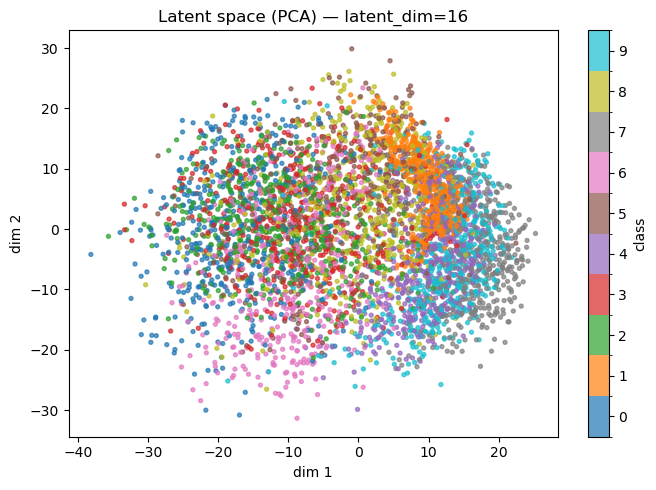

In [9]:
from sklearn.decomposition import PCA
import matplotlib.colors as mcolors

def scatter_2d(A2, labels, title: str, n_classes: int = 10):
    """Scatter plot with discrete colormap for class labels."""
    fig, ax = plt.subplots(figsize=(7, 5))
    
    # Use tab10 qualitative colormap (designed for 10 distinct categories)
    cmap = plt.cm.tab10
    bounds = np.arange(n_classes + 1) - 0.5
    norm = mcolors.BoundaryNorm(bounds, cmap.N)
    
    sc = ax.scatter(A2[:, 0], A2[:, 1], c=labels, cmap=cmap, norm=norm, s=8, alpha=0.7)
    ax.set_title(title)
    ax.set_xlabel("dim 1")
    ax.set_ylabel("dim 2")
    
    # Discrete colorbar with class labels
    cbar = fig.colorbar(sc, ax=ax, ticks=np.arange(n_classes))
    cbar.set_label("class")
    
    plt.tight_layout()
    plt.show()

# Apply PCA to reduce latent space to 2D and plot
pca = PCA(n_components=2, random_state=cfg.seed)
Z_pca = pca.fit_transform(Z)
scatter_2d(Z_pca, Y, f"Latent space (PCA) — latent_dim={cfg.latent_dim}")

- **UMAP** often reveals non-linear structure. Takes a minute to run.

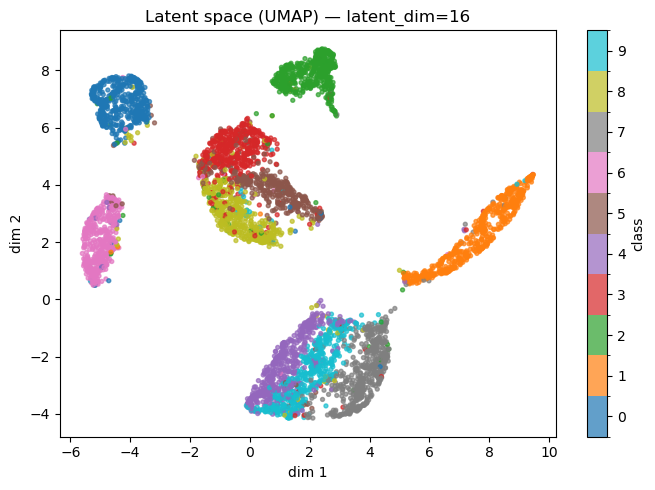

In [10]:
# Try UMAP if available
try:
    import umap
    # n_jobs=1 required when random_state is set (reproducibility disables parallelism)
    reducer = umap.UMAP(n_components=2, random_state=cfg.seed, n_jobs=1)
    Z_umap = reducer.fit_transform(Z)
    scatter_2d(Z_umap, Y, f"Latent space (UMAP) — latent_dim={cfg.latent_dim}")
except Exception as e:
    print("UMAP not available (this is ok). Error:", repr(e))

## 8. Latent interpolation

**Latent interpolation** is a powerful technique for probing what an autoencoder has learned. The idea is simple:

1. Take two input images $x_A$ and $x_B$
2. Encode them to latent vectors $z_A = \text{encode}(x_A)$ and $z_B = \text{encode}(x_B)$
3. Create intermediate points along the line between them: $z_\alpha = (1 - \alpha) z_A + \alpha z_B$ for $\alpha \in [0, 1]$
4. Decode each intermediate point: $\hat{x}_\alpha = \text{decode}(z_\alpha)$

### Interpreting the output

- **Smooth transitions** between decoded images suggest the latent space is *continuous* and well-organised — nearby points in latent space correspond to semantically similar images.
- **Abrupt changes** or artifacts indicate "holes" in the latent space where the decoder hasn't learned meaningful structure.
- For digits, you might see a "3" gradually morph into an "8" through plausible intermediate forms.

### Connection to generative models

This property — that you can move smoothly through latent space and get coherent outputs — is foundational for:
- **VAEs**: regularise the latent space to be smooth and sampleable
- **GANs**: latent interpolation ("latent walks") reveal what the generator has learned
- **Diffusion models**: operate in latent space for efficiency (Stable Diffusion)

A well-trained autoencoder should produce smooth, semantically meaningful interpolations rather than noisy transitions.

Interpolating between indices: 860 3772


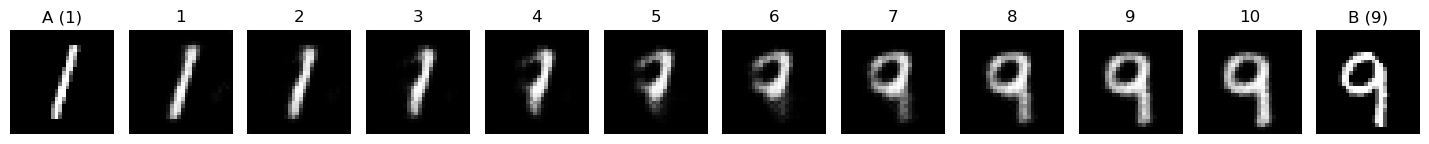

In [11]:
def show_latent_interpolation(model, ds, idx_a: int, idx_b: int, steps: int = 10):
    """
    Show interpolation in latent space between two dataset samples.
    
    Args:
        model: The autoencoder model.
        ds: Dataset to sample from.
        idx_a: Index of the first sample.
        idx_b: Index of the second sample.
        steps: Number of interpolation steps between the two samples.

    Returns:
        None (displays a plot).
    """
    model.eval() # set eval mode

    # Get the two samples
    xa, ya = ds[idx_a]
    xb, yb = ds[idx_b]
    xa = xa.unsqueeze(0).to(device) # add batch dimension
    xb = xb.unsqueeze(0).to(device)

    # Compute latent representations
    with torch.no_grad(): # disable gradients
        za = model.encode(xa)
        zb = model.encode(xb)

        # Interpolate in latent space
        alphas = torch.linspace(0, 1, steps, device=device).view(-1,1)
        z_interp = (1 - alphas) * za + alphas * zb
        x_interp = model.decode(z_interp).cpu()

    # Plot the results
    fig, axes = plt.subplots(1, steps + 2, figsize=(1.2*(steps+2), 2))
    axes[0].imshow(xa.cpu()[0,0], cmap="gray"); axes[0].set_title(f"A ({int(ya)})"); axes[0].axis("off")
    for i in range(steps):
        axes[i+1].imshow(x_interp[i,0], cmap="gray"); axes[i+1].set_title(f"{i+1}"); axes[i+1].axis("off")
    axes[-1].imshow(xb.cpu()[0,0], cmap="gray"); axes[-1].set_title(f"B ({int(yb)})"); axes[-1].axis("off")
    plt.tight_layout()
    plt.show()

# Choose two random test indices and show interpolation
idx_a = np.random.randint(0, len(test_ds_small))
idx_b = np.random.randint(0, len(test_ds_small))
print("Interpolating between indices:", idx_a, idx_b)
show_latent_interpolation(model, test_ds_small, idx_a, idx_b, steps=10)


## 9. Latent traversal (vary one dimension)

**Latent traversals** (also called "latent walks" or "dimension sweeps") help us understand what each dimension of the latent space encodes.

### How it works

1. Encode an image to get its latent vector $z = [z_1, z_2, \ldots, z_d]$
2. Pick one dimension $i$ to vary
3. Sweep $z_i$ across a range (e.g., $z_i \pm 3$) while keeping all other dimensions fixed
4. Decode each modified vector and observe how the output changes

### What to look for

- **Interpretable factors**: In a well-structured latent space, individual dimensions may capture meaningful attributes:
  - For digits: stroke thickness, slant, width, loop size
  - For faces: pose, lighting, expression, age
  - For galaxies: morphology, orientation, brightness
  
- **Entangled vs disentangled**: 
  - *Disentangled*: each dimension controls one independent factor (ideal)
  - *Entangled*: changing one dimension affects multiple attributes (common in standard autoencoders)

- **Smooth changes**: Gradual visual changes indicate the decoder has learned a continuous mapping

### Why this matters

Latent traversals are a key diagnostic for:
- **Interpretability**: understanding what the model has learned
- **Controllable generation**: if dimensions are disentangled, you can edit specific attributes
- **Debugging**: erratic outputs suggest the dimension encodes noise or the model is undertrained

VAEs and β-VAE tend to learn more disentangled representations than standard autoencoders, making traversals more interpretable.

Traversal idx: 3092 dim: 6


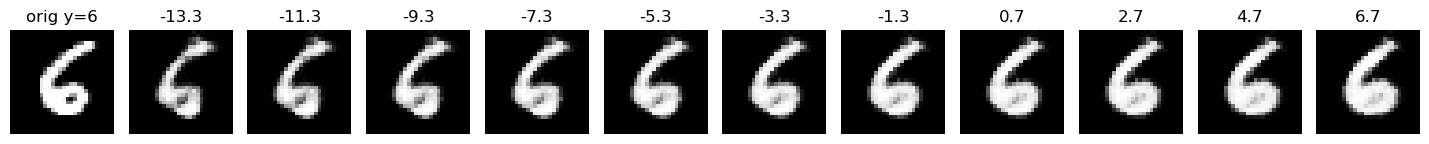

In [12]:
def show_latent_traversal(model, ds, idx: int, dim: int = 0, n_steps: int = 11, span: float = 3.0):
    """
    Show latent space traversal along a specified dimension for a given sample.
    
    Args:
        model: The autoencoder model.
        ds: Dataset to sample from.
        idx: Index of the sample to traverse.
        dim: Latent dimension to vary.
        n_steps: Number of steps in the traversal.
        span: Range to traverse around the original latent value.

    Returns:
        
    """
    model.eval() # set eval mode

    # Get the sample
    x, y = ds[idx]
    x = x.unsqueeze(0).to(device)


    with torch.no_grad():
        # Original latent representation
        z0 = model.encode(x).squeeze(0)
        # Sample values around the current coordinate
        vals = torch.linspace(-span, span, n_steps, device=device) + z0[dim]
        # Create latent vectors for traversal       
        Zs = z0.repeat(n_steps, 1)
        Zs[:, dim] = vals
        # Decode the traversed latent vectors
        xs = model.decode(Zs).cpu()

    # Plot the results
    fig, axes = plt.subplots(1, n_steps + 1, figsize=(1.2*(n_steps+1), 2))
    axes[0].imshow(x.cpu()[0,0], cmap="gray")
    axes[0].set_title(f"orig y={int(y)}")
    axes[0].axis("off")
    for i in range(n_steps):
        axes[i+1].imshow(xs[i,0], cmap="gray")
        axes[i+1].set_title(f"{vals[i].item():.1f}")
        axes[i+1].axis("off")
    plt.tight_layout()
    plt.show()

# Choose a random test index and latent dimension to traverse
idx = np.random.randint(0, len(test_ds_small))
dim = np.random.randint(0, cfg.latent_dim)
print("Traversal idx:", idx, "dim:", dim)
show_latent_traversal(model, test_ds_small, idx=idx, dim=dim, n_steps=11, span=10.0)

## 10. Are the embeddings useful?

A very common “foundation model” pattern is:

1. Freeze an encoder that produces embeddings.
2. Train a tiny model on top (linear probe / kNN).

Here we do **kNN classification** in latent space as a quick check.


In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Build a train embedding set for kNN
Ztr, Ytr = collect_latents(model, DataLoader(train_ds_small, batch_size=cfg.batch_size, shuffle=False, num_workers=0))

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(Ztr, Ytr)
pred = knn.predict(Z)
acc = accuracy_score(Y, pred)
print(f"kNN accuracy using latent embeddings: {acc:.3f}")

kNN accuracy using latent embeddings: 0.953


Now let's visualise the results.

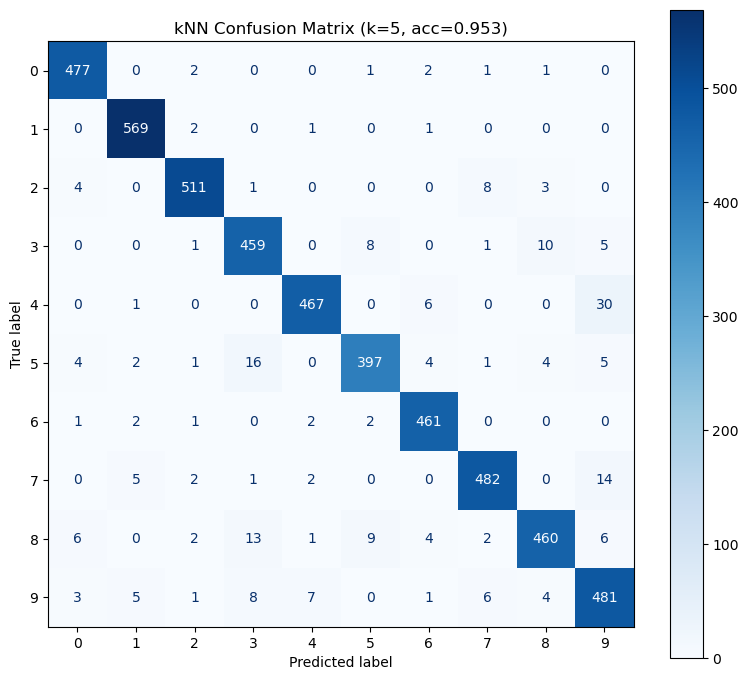

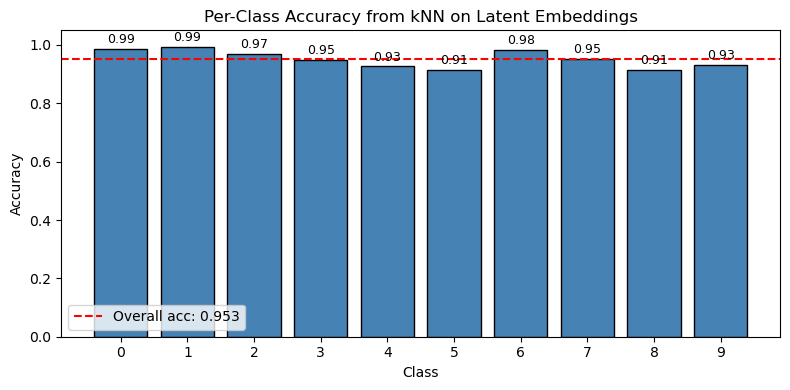

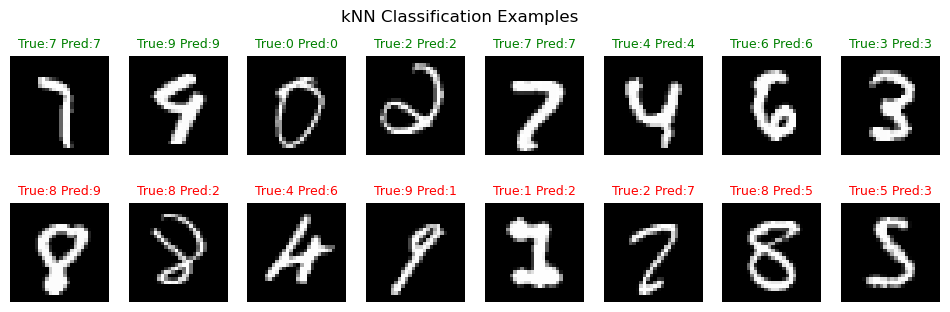


Correct: 4764 / 5000 (95.3%)
Misclassified: 236 / 5000 (4.7%)


In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# --- Confusion matrix ---
cm = confusion_matrix(Y, pred, labels=np.arange(n_classes))
fig, ax = plt.subplots(figsize=(8, 7))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(n_classes))
disp.plot(ax=ax, cmap="Blues", colorbar=True)
ax.set_title(f"kNN Confusion Matrix (k=5, acc={acc:.3f})")
plt.tight_layout()
plt.show()

# --- Per-class accuracy ---
per_class_acc = cm.diagonal() / cm.sum(axis=1)
fig, ax = plt.subplots(figsize=(8, 4))
bars = ax.bar(np.arange(n_classes), per_class_acc, color="steelblue", edgecolor="black")
ax.axhline(acc, color="red", linestyle="--", label=f"Overall acc: {acc:.3f}")
ax.set_xlabel("Class")
ax.set_ylabel("Accuracy")
ax.set_title("Per-Class Accuracy from kNN on Latent Embeddings")
ax.set_xticks(np.arange(n_classes))
ax.set_ylim(0, 1.05)
ax.legend()
for i, v in enumerate(per_class_acc):
    ax.text(i, v + 0.02, f"{v:.2f}", ha="center", fontsize=9)
plt.tight_layout()
plt.show()

# --- Examples: correct and incorrect classifications ---
correct_mask = (pred == Y)
incorrect_mask = ~correct_mask

# Get indices for correct and incorrect predictions
correct_idx = np.where(correct_mask)[0]
incorrect_idx = np.where(incorrect_mask)[0]

# Sample up to 8 of each
n_examples = min(8, len(correct_idx), len(incorrect_idx)) if len(incorrect_idx) > 0 else min(8, len(correct_idx))

fig, axes = plt.subplots(2, n_examples, figsize=(1.5 * n_examples, 3.5))
if n_examples == 1:
    axes = axes.reshape(2, 1)

# Show correct predictions
for i in range(n_examples):
    idx = correct_idx[i]
    # Find original image from test dataset
    orig_idx = test_ds_small.indices[idx] if hasattr(test_ds_small, 'indices') else idx
    img, _ = test_ds[orig_idx] if hasattr(test_ds_small, 'indices') else test_ds_small[idx]
    axes[0, i].imshow(img[0], cmap="gray")
    axes[0, i].set_title(f"True:{Y[idx]} Pred:{pred[idx]}", fontsize=9, color="green")
    axes[0, i].axis("off")

# Show incorrect predictions
if len(incorrect_idx) > 0:
    for i in range(min(n_examples, len(incorrect_idx))):
        idx = incorrect_idx[i]
        orig_idx = test_ds_small.indices[idx] if hasattr(test_ds_small, 'indices') else idx
        img, _ = test_ds[orig_idx] if hasattr(test_ds_small, 'indices') else test_ds_small[idx]
        axes[1, i].imshow(img[0], cmap="gray")
        axes[1, i].set_title(f"True:{Y[idx]} Pred:{pred[idx]}", fontsize=9, color="red")
        axes[1, i].axis("off")
    # Hide unused subplots
    for i in range(len(incorrect_idx), n_examples):
        axes[1, i].axis("off")
else:
    for i in range(n_examples):
        axes[1, i].axis("off")
    axes[1, 0].text(0.5, 0.5, "No misclassifications!", ha="center", va="center", fontsize=12)

axes[0, 0].set_ylabel("Correct", fontsize=11)
axes[1, 0].set_ylabel("Incorrect", fontsize=11)
plt.suptitle("kNN Classification Examples", fontsize=12)
#plt.tight_layout()
plt.show()

print(f"\nCorrect: {correct_mask.sum()} / {len(Y)} ({100*correct_mask.mean():.1f}%)")
print(f"Misclassified: {incorrect_mask.sum()} / {len(Y)} ({100*incorrect_mask.mean():.1f}%)")

## 11. Variational Autoencoder (VAE)

A **Variational Autoencoder (VAE)** learns a *probabilistic* latent space.  
Instead of mapping an input to a single latent vector `z`, the encoder predicts a **distribution**:

- mean: $\mu(x)$
- log-variance: $\log \sigma^2(x)$

Then we sample using the **reparameterisation trick**:

$$z = \mu + \sigma \cdot \epsilon, \quad \epsilon \sim \mathcal{N}(0, I)$$

Training minimises a combination of:
1. **Reconstruction loss**: make the decoded output match the input
2. **KL divergence**: keep the latent distribution close to a unit Gaussian

$$\mathcal{L} = \mathbb{E}[\text{recon}(x, \hat{x})] + \beta \, D_{KL}(q(z|x) \,||\, \mathcal{N}(0,I))$$

### Why VAEs for latent-space intuition?
- The latent space becomes **smooth** and **sampleable**
- Interpolations tend to look more coherent
- You can generate new samples by drawing $z \sim \mathcal{N}(0, I)$ and decoding

In [16]:
# VAE model (small convolutional)
class ConvVAE(nn.Module):
    def __init__(self, latent_dim: int = 16):
        super().__init__()
        # Encoder conv stack
        self.enc = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  # (B,16,14,14)
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # (B,32,7,7)
            nn.ReLU(),
        )
        self.enc_fc_mu = nn.Linear(32 * 7 * 7, latent_dim)
        self.enc_fc_logvar = nn.Linear(32 * 7 * 7, latent_dim)

        # Decoder
        self.dec_fc = nn.Linear(latent_dim, 32 * 7 * 7)
        self.dec = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 4, stride=2, padding=1),  # (B,16,14,14)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 4, stride=2, padding=1),   # (B,1,28,28)
            nn.Sigmoid(),
        )

    def encode(self, x):
        h = self.enc(x).view(x.size(0), -1)
        mu = self.enc_fc_mu(h)
        logvar = self.enc_fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + std * eps

    def decode(self, z):
        h = self.dec_fc(z).view(z.size(0), 32, 7, 7)
        return self.dec(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decode(z)
        return x_hat, mu, logvar, z

vae = ConvVAE(latent_dim=cfg.latent_dim).to(device)
vae_opt = torch.optim.Adam(vae.parameters(), lr=cfg.lr)

def vae_loss(x_hat, x, mu, logvar, beta: float = 1.0):
    # Reconstruction: sum over pixels (not mean) to balance with KL
    recon = torch.sum((x_hat - x) ** 2, dim=(1, 2, 3))  # per-sample, summed over pixels
    # KL divergence: sum over latent dimensions
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
    # Average over batch
    loss = torch.mean(recon + beta * kl)
    return loss, recon.mean().item(), kl.mean().item()

print(vae)

ConvVAE(
  (enc): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
  )
  (enc_fc_mu): Linear(in_features=1568, out_features=16, bias=True)
  (enc_fc_logvar): Linear(in_features=1568, out_features=16, bias=True)
  (dec_fc): Linear(in_features=16, out_features=1568, bias=True)
  (dec): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(16, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): Sigmoid()
  )
)


VAE Training:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1 (β=0.50):   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 01 | β=0.50 | loss 80.7 | recon 75.0 | kl 11.3


Epoch 2 (β=1.00):   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 02 | β=1.00 | loss 46.9 | recon 38.2 | kl 8.7


Epoch 3 (β=1.00):   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 03 | β=1.00 | loss 40.4 | recon 29.7 | kl 10.7


Epoch 4 (β=1.00):   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 04 | β=1.00 | loss 37.6 | recon 25.9 | kl 11.7


Epoch 5 (β=1.00):   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 05 | β=1.00 | loss 36.2 | recon 24.2 | kl 12.0


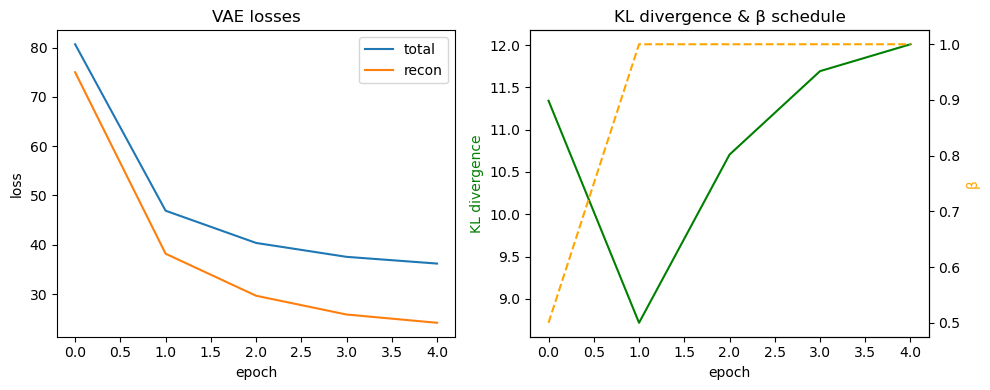

In [17]:
# Train VAE with KL annealing
vae_history = {"loss": [], "recon": [], "kl": [], "beta": []}

beta_max = 1.0      # final beta value
warmup_epochs = 2   # epochs to linearly ramp beta from 0 to beta_max

for epoch in tqdm(range(1, cfg.epochs + 1), desc="VAE Training"):
    # KL annealing: linearly increase beta during warmup
    if epoch <= warmup_epochs:
        beta = beta_max * (epoch / warmup_epochs)
    else:
        beta = beta_max
    
    vae.train(True)
    total_loss = total_recon = total_kl = 0.0
    n = 0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch} (β={beta:.2f})", leave=False)
    for x, _y in pbar:
        x = x.to(device)
        vae_opt.zero_grad(set_to_none=True)
        x_hat, mu, logvar, _z = vae(x)
        loss, recon_m, kl_m = vae_loss(x_hat, x, mu, logvar, beta=beta)
        loss.backward()
        vae_opt.step()

        bs = x.size(0)
        total_loss += loss.item() * bs
        total_recon += recon_m * bs
        total_kl += kl_m * bs
        n += bs
        pbar.set_postfix(loss=total_loss / n, recon=total_recon / n, kl=total_kl / n)

    vae_history["loss"].append(total_loss / n)
    vae_history["recon"].append(total_recon / n)
    vae_history["kl"].append(total_kl / n)
    vae_history["beta"].append(beta)

    print(f"Epoch {epoch:02d} | β={beta:.2f} | loss {vae_history['loss'][-1]:.1f} | recon {vae_history['recon'][-1]:.1f} | kl {vae_history['kl'][-1]:.1f}")

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].plot(vae_history["loss"], label="total")
axes[0].plot(vae_history["recon"], label="recon")
axes[0].set_xlabel("epoch")
axes[0].set_ylabel("loss")
axes[0].legend()
axes[0].set_title("VAE losses")

axes[1].plot(vae_history["kl"], label="KL", color="green")
ax2 = axes[1].twinx()
ax2.plot(vae_history["beta"], label="β", color="orange", linestyle="--")
axes[1].set_xlabel("epoch")
axes[1].set_ylabel("KL divergence", color="green")
ax2.set_ylabel("β", color="orange")
axes[1].set_title("KL divergence & β schedule")

plt.tight_layout()
plt.show()

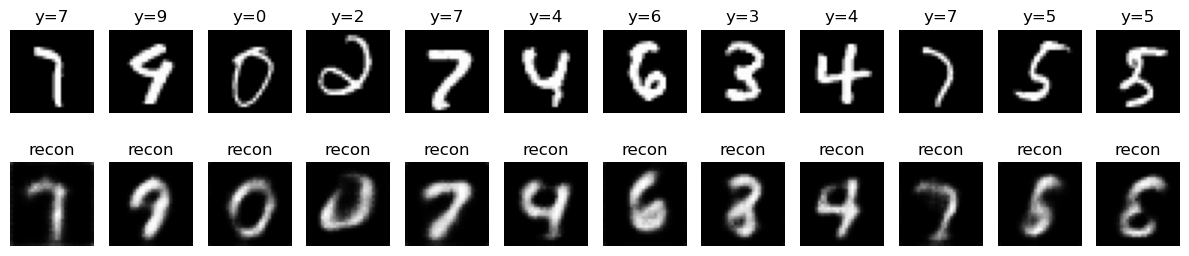

Latent batch shape: torch.Size([128, 16])


In [18]:
# Reconstructions (VAE)
vae.eval()
x, y = next(iter(test_loader))
x = x.to(device)
with torch.no_grad():
    x_hat, mu, logvar, z = vae(x)

x = x.cpu()
x_hat = x_hat.cpu()
n_show = 12

fig, axes = plt.subplots(2, n_show, figsize=(12, 3))
for i in range(n_show):
    axes[0, i].imshow(x[i,0], cmap="gray")
    axes[0, i].set_title(f"y={int(y[i])}")
    axes[0, i].axis("off")
    axes[1, i].imshow(x_hat[i,0], cmap="gray")
    axes[1, i].set_title("recon")
    axes[1, i].axis("off")
plt.tight_layout()
plt.show()

print("Latent batch shape:", z.shape)


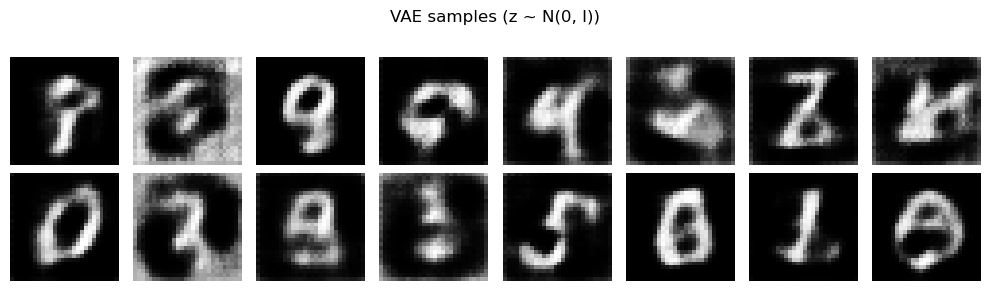

In [19]:
# Sampling: generate new images by sampling z ~ N(0, I)
vae.eval()
n_gen = 16
with torch.no_grad():
    z = torch.randn(n_gen, cfg.latent_dim, device=device)
    x_gen = vae.decode(z).cpu()

fig, axes = plt.subplots(2, 8, figsize=(10, 3))
for i, ax in enumerate(axes.flat):
    ax.imshow(x_gen[i,0], cmap="gray")
    ax.axis("off")
plt.suptitle("VAE samples (z ~ N(0, I))")
plt.tight_layout()
plt.show()


VAE interpolation between indices: 466 4426


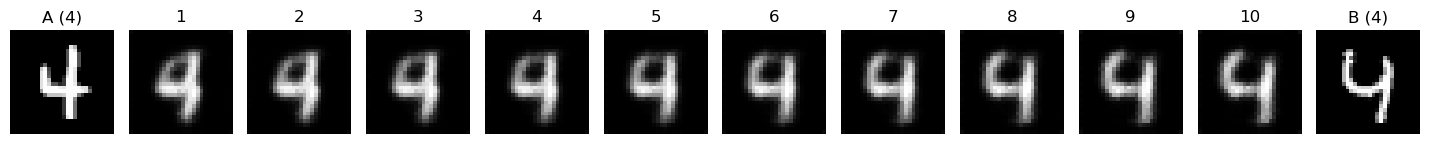

In [20]:
# Latent interpolation (VAE) — uses the *mean* mu for stability
def show_vae_interpolation(vae, ds, idx_a: int, idx_b: int, steps: int = 10):
    vae.eval()
    xa, ya = ds[idx_a]
    xb, yb = ds[idx_b]
    xa = xa.unsqueeze(0).to(device)
    xb = xb.unsqueeze(0).to(device)

    with torch.no_grad():
        mua, _lva = vae.encode(xa)
        mub, _lvb = vae.encode(xb)

        alphas = torch.linspace(0, 1, steps, device=device).view(-1,1)
        z_interp = (1 - alphas) * mua + alphas * mub
        x_interp = vae.decode(z_interp).cpu()

    fig, axes = plt.subplots(1, steps + 2, figsize=(1.2*(steps+2), 2))
    axes[0].imshow(xa.cpu()[0,0], cmap="gray"); axes[0].set_title(f"A ({int(ya)})"); axes[0].axis("off")
    for i in range(steps):
        axes[i+1].imshow(x_interp[i,0], cmap="gray"); axes[i+1].set_title(f"{i+1}"); axes[i+1].axis("off")
    axes[-1].imshow(xb.cpu()[0,0], cmap="gray"); axes[-1].set_title(f"B ({int(yb)})"); axes[-1].axis("off")
    plt.tight_layout()
    plt.show()

idx_a = np.random.randint(0, len(test_ds_small))
idx_b = np.random.randint(0, len(test_ds_small))
print("VAE interpolation between indices:", idx_a, idx_b)
show_vae_interpolation(vae, test_ds_small, idx_a, idx_b, steps=10)


## Exercise: Apply to MiraBest Radio Galaxies

Now apply what you've learned to a real astronomy dataset!

**MiraBest** is a labelled dataset of Fanaroff-Riley (FR) radio galaxies from the FIRST survey:
- **FRI** (class 0): edge-darkened — jets fade with distance from the core
- **FRII** (class 1): edge-brightened — jets terminate in bright hotspots
- ~800 images total (150×150 grayscale)
- Zenodo: https://doi.org/10.5281/zenodo.4288837

### Data format

MiraBest uses a **CIFAR-style pickle format** (not PNG files):
- Download `batches.tar.gz` (~136 MB) from Zenodo
- Extract to get `data_batch_1`, `data_batch_2`, ... files
- Each batch is a Python pickle containing:
  - `data`: list of 150×150 numpy arrays
  - `labels`: list of class labels (0=FRI, 1=FRII)

### Tasks

1. **Download and load MiraBest** — extract the tarball and load pickle batches

2. **Create a Dataset class** that:
   - Loads images from pickle batches
   - Resizes 150×150 images to 64×64 for the autoencoder

3. **Adapt the autoencoder** for 64×64 images
   - Hint: after two stride-2 convolutions, you get 64→32→16
   - Flattened size becomes 32 × 16 × 16 = 8192

4. **Train and visualise**:
   - Reconstructions — do jets and lobes appear?
   - PCA/UMAP of latent space coloured by FR class
   - Latent interpolation between an FRI and FRII galaxy

5. **Evaluate with kNN** — can embeddings distinguish FR classes?
   - Random baseline is 50% (binary classification)

### Solution

See **Session1A_Extension_MiraBest.ipynb** for a complete worked solution.